In [32]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [33]:
image_path = 'img/1.jpg'

# Load the image
image = cv2.imread(image_path)

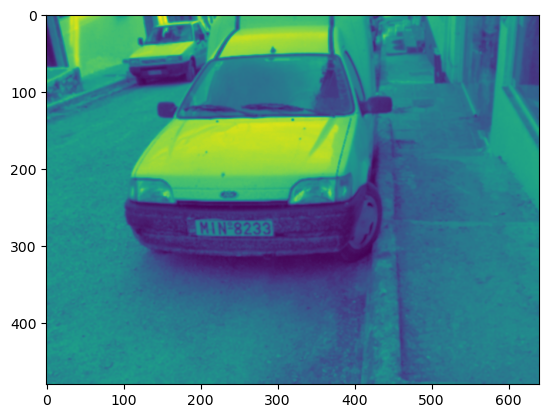

In [34]:
# Convert to grayscale
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Apply Gaussian blur to reduce noise
blurred = cv2.GaussianBlur(gray, (5,5), 0)
plt.imshow(blurred)

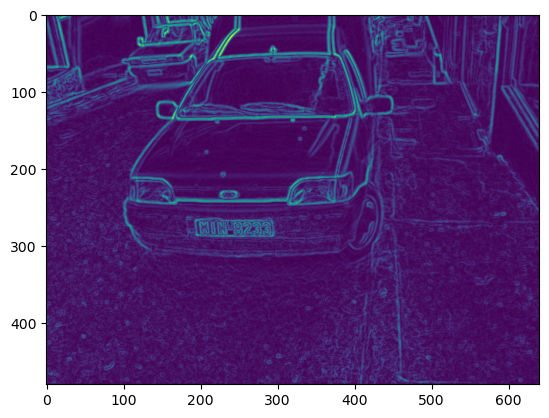

In [35]:
# Edge detection using Sobel operator
sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
abs_grad_x = cv2.convertScaleAbs(sobelx)
abs_grad_y = cv2.convertScaleAbs(sobely)
grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)
plt.imshow(grad)

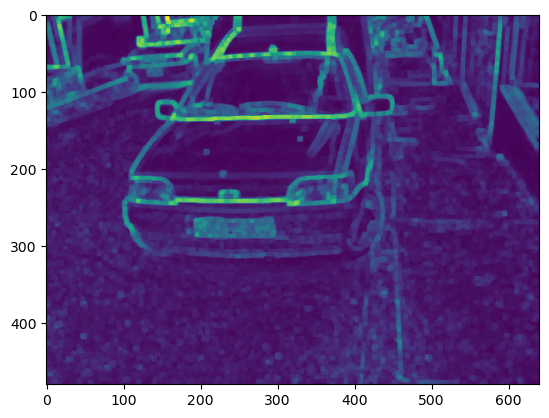

In [36]:
# Morphological operations to enhance edges
kernel = np.ones((3,3),np.uint8)
    
# Opening operation to remove noise
opening = cv2.morphologyEx(grad, cv2.MORPH_OPEN, kernel)
    
dilation = cv2.dilate(opening, kernel, iterations = 1)  # Dilation on "opening" result
closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)

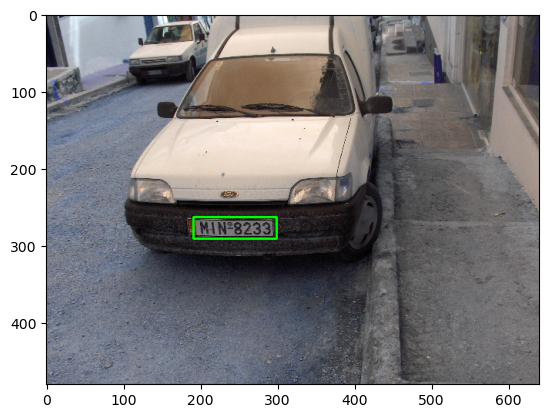

In [37]:
# Thresholding to binarize the image
thresh = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

# Find contours 
contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filter contours based on aspect ratio and area
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    aspect_ratio = float(w) / h
    area = w * h

    # Check if the contour has characteristics of a license plate
    if aspect_ratio >= 2 and aspect_ratio <= 5 and area > 1000: 
        # Draw bounding box around potential license plate
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

plt.imshow(image)

In [38]:
def calculate_f1_score(ground_truth, predicted):
    """
    Zemin gerçek ve tahmin edilen maskeler arasındaki F1 skorunu hesaplar.
    """
    tp = np.sum(np.logical_and(ground_truth, predicted))
    fp = np.sum(np.logical_and(np.logical_not(ground_truth), predicted))
    fn = np.sum(np.logical_and(ground_truth, np.logical_not(predicted)))

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1

def process_image(image_path):
    """
    Resmi işler, plakayı algılar ve tahmin edilen maskeyi döndürür.
    """
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (13, 13), 0)

    sobelx = cv2.Sobel(blurred, cv2.CV_64F, 1, 0, ksize=3)
    sobely = cv2.Sobel(blurred, cv2.CV_64F, 0, 1, ksize=3)
    abs_grad_x = cv2.convertScaleAbs(sobelx)
    abs_grad_y = cv2.convertScaleAbs(sobely)
    grad = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)

    kernel = np.ones((3, 3), np.uint8)
    opening = cv2.morphologyEx(grad, cv2.MORPH_OPEN, kernel)
    dilation = cv2.dilate(opening, kernel, iterations=1)
    closing = cv2.morphologyEx(dilation, cv2.MORPH_CLOSE, kernel)

    thresh = cv2.threshold(closing, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    predicted_mask = np.zeros_like(gray)
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        aspect_ratio = float(w) / h
        area = w * h

        if aspect_ratio >= 2 and aspect_ratio <= 5 and area > 1000:
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
            cv2.fillPoly(predicted_mask, pts=[np.array([[x, y], [x+w, y], [x+w, y+h], [x, y+h]])], color=255)

    return image, predicted_mask

In [39]:
# Resim yollarını tanımla
image_names = ["1.jpg", "2.jpg", "27.jpg", "31.jpg", "43.jpg"]
image_paths = [os.path.join("img", name) for name in image_names]
ground_truth_paths = [os.path.join("validation", name[:-4] + ".png") for name in image_names]

# Resimleri işle, tahmin edilen maskeleri oluştur ve F1 skorlarını hesapla
processed_images = []
f1_scores = []

In [40]:
for image_path, ground_truth_path in zip(image_paths, ground_truth_paths):
    processed_image, predicted_mask = process_image(image_path)

    ground_truth = cv2.imread(ground_truth_path)
    # Açık yeşili yakalamak için renk aralığı kontrolü. VALIDATION RESIMLERINDE ACIK YESILLE CIZDIM PLAKANIN ETRAFINI
    lower_green = np.array([50, 200, 50], dtype="uint8")
    upper_green = np.array([150, 255, 150], dtype="uint8")
    ground_truth_mask = cv2.inRange(ground_truth, lower_green, upper_green)

    # Zemin gerçek maskesini genişlet
    kernel = np.ones((7, 7), np.uint8)  # Genişletme için çekirdek
    ground_truth_mask = cv2.dilate(ground_truth_mask, kernel, iterations=2) 

    f1 = calculate_f1_score(ground_truth_mask, predicted_mask)
    f1_scores.append(f1)
    processed_images.append(processed_image)

    cv2.putText(processed_image, f"F1: {f1:.2f}", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

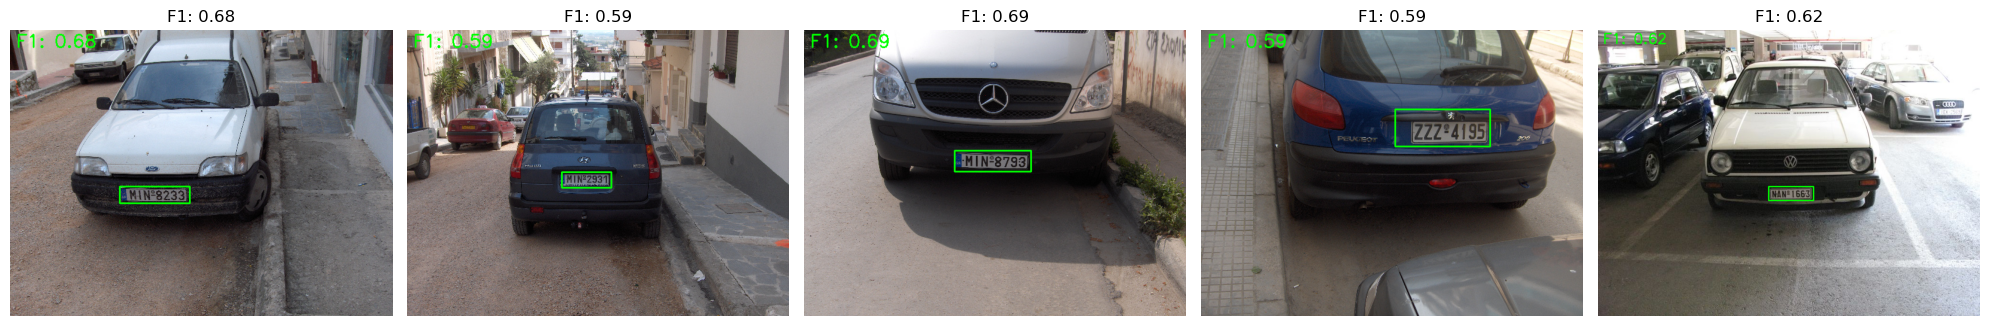

In [41]:
# Tüm resim sonuçlarını tek bir Matplotlib grafiğinde görüntüle
fig, axes = plt.subplots(1, len(processed_images), figsize=(20, 4))
for i, (image, f1) in enumerate(zip(processed_images, f1_scores)):
    axes[i].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f"F1: {f1:.2f}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()